# 🏗️Importar bibliotecas necesarias

In [19]:
# Importar librerias de data-science
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Importar Librerias de visualización
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Librerias Tensorflow
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# Librerias de sistema
from pathlib import Path
import os.path

# Metricas
from sklearn.metrics import classification_report, confusion_matrix

# 🤙Crear funciones auxiliares

In [20]:
### Creamos un montón de funciones útiles a lo largo del curso.
### Almacenándolos aquí para que sean fácilmente accesibles.

import tensorflow as tf

# Crea una función para importar una imagen y redimensionarla para poder usarla con nuestro modelo
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Lee una imagen del nombre de archivo, la convierte en un tensor y la transforma en
  (224, 224, 3).

  Parametros
  ----------
  filename (str): cadena de nombre de archivo de la imagen de destino
  img_shape (int): tamaño para cambiar el tamaño de la imagen de destino, predeterminado 224
  scale (bool): si se escalan los valores de píxeles al rango (0, 1), por defecto True
  """
  #Lee la imagen
  img = tf.io.read_file(filename)
  # Decodificarlo en un tensor
  img = tf.image.decode_jpeg(img)
  # Cambiar el tamaño de la imagen
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Reescalar la imagen (obtener todos los valores entre 0 y 1)
    return img/255.
  else:
    return img

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Nuestra función necesita un nombre diferente a plot_confusion_matrix de sklearn
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Crea una matriz de confusión etiquetada que compara las predicciones y las etiquetas de verdad.

  Si se pasan clases, se etiquetará la matriz de confusión, si no, valores enteros
  se utilizará.

  Argumentos:
    y_true: matriz de etiquetas de verdad (debe tener la misma forma que y_pred).
    y_pred: matriz de etiquetas previstas (debe tener la misma forma que y_true).
    classes: matriz de etiquetas de clase (por ejemplo, forma de cadena). Si `None`, se utilizan etiquetas de enteros.
    figsize: Tamaño de la figura de salida (predeterminado=(10, 10)).
    text_size: tamaño del texto de la figura de salida (predeterminado = 15).
    norm: normalizar valores o no (predeterminado=Falso).
    savefig: guarda la matriz de confusión en el archivo (predeterminado = Falso).
  
  Retorna:
    Una gráfica de matriz de confusión etiquetada que compara y_true e y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # Etiquetas de prueba de verdad
                          y_pred=y_preds, # Etiquetas predichas
                          classes=class_names, # Matriz de nombres de etiquetas de clase
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Crear la matriz de confusión
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # Se normaliza
  n_classes = cm.shape[0] # Encuentra el número de clases con las que estamos tratando

  # Traza la figura y hazla bonita
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # Los colores representarán cuán "correcta" es una clase, más oscura == mejor
  fig.colorbar(cax)

  # ¿Hay una lista de clases?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Etiquetar los ejes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # Crear suficientes ranuras de eje para cada clase
         yticks=np.arange(n_classes), 
         xticklabels=labels, # Los ejes se etiquetarán con nombres de clase (si existen) o ints
         yticklabels=labels)
  
  # Hacer que las etiquetas del eje X aparezcan en la parte inferior
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Establecer el umbral para diferentes colores
  threshold = (cm.max() + cm.min()) / 2.

  # Trazar el texto en cada celda
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Guarde la figura en el directorio de trabajo actual
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Hacer una función para predecir imágenes y trazarlas (funciona con multiclase)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Importar la imagen de destino y preprocesarla
  img = load_and_prep_image(filename)

  # Hacer una predicción
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Obtenga la clase prevista
  if len(pred[0]) > 1: # Comprobar si hay multiclase
    pred_class = class_names[pred.argmax()] # Si hay más de una salida, tome el máximo
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # Si sólo hay una salida, redondear

  # Trazar la imagen y predecir la clase
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Crea un instand de devolución de llamada de TensorBoard para almacenar archivos de registro.

  Almacena archivos de registro con la ruta de archivo: 
    "dir_name/experiment_name/current_datetime/"

  Argumentos:
    dir_name: directorio de destino para almacenar los archivos de registro de TensorBoard 
    experiment_name: nombre del directorio del experimento (por ejemplo, efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Guardar archivos de registro de TensorBoard en: {log_dir}")
  return tensorboard_callback

# Trazar los datos de validación y entrenamiento por separado
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Devuelve curvas de pérdida separadas para las métricas de entrenamiento y validación.

  Argumentos:
    history: Objeto History del modelo TensorFlow (Mirar: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compara dos objetos History del modelo TensorFlow.
    
    Argumentos:
      original_history: Objeto History del modelo original (antes new_history)
      new_history: Objeto History del entrenamiento continuo del modelo (después de original_history)
      initial_epochs: Número de épocas en original_history (el plan new_history comienza desde aquí)
    """
    
    # Obtenga mediciones de la historia original
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combina la historia original con la nueva historia
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Hacer parcelas
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # Recambiar la trama alrededor de las épocas
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # Recambiar la trama alrededor de las épocas
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Crear función para descomprimir un archivo zip en el directorio de trabajo actual 
# (ya que vamos a descargar y descomprimir algunos archivos)
import zipfile

def unzip_data(filename):
  """
  Descomprime el nombre de archivo en el directorio de trabajo actual.

  Args:
    filename (str): Una ruta de archivo a una carpeta ZIP de destino que se va a descomprimir.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Recorra un directorio de clasificación de imágenes y averigüe cuántos archivos (imágenes) 
# están en cada subdirectorio.
import os

def walk_through_dir(dir_path):
  """
  Recorre dir_path devolviendo su contenido.

  Argumentos:
    dir_path (str): directorio destino
  
  Retorna:
    Una impresión de:
      número de subdirectorios en dir_path
      número de imágenes (archivos) en cada subdirectorio
      nombre de cada subdirectorio
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Hay {len(dirnames)} directorios {len(filenames)} imagenes en '{dirpath}'.")
    
# Función a evaluar: exactitud, precisión, recuperación, puntuación f1
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calcule la exactitud, la precisión, la recuperación y la puntuación f1 del modelo de un modelo de clasificación binaria.

  Args:
      y_true: etiquetas verdaderas en forma de matriz 1D
      y_pred: etiquetas predichas en forma de matriz 1D

  Devuelve un diccionario de exactitud, precisión, recuperación, puntuación f1.
  """
  # Calcular la precisión del modelo
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calcule la precisión del modelo, la recuperación y la puntuación f1 utilizando el "promedio ponderado"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


# 📥Cargar y transformar datos

In [22]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [23]:
# Recorra cada directorio
dataset = "../input/insect-village-synthetic-dataset/Insect Classes"
walk_through_dir(dataset)

# 📅Colocar datos en un marco de datos
La primera columna `filepaths` contiene la ubicación de la ruta del archivo de cada imagen individual. La segunda columna `etiquetas`, por otro lado, contiene la etiqueta de clase de la imagen correspondiente de la ruta del archivo

In [24]:
image_dir = Path(dataset)

# Obtener rutas de archivo y etiquetas
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenar rutas de archivo y etiquetas
image_df = pd.concat([filepaths, labels], axis=1)

In [25]:
image_df

,Filepath,Label


# 🔭Visualización de imágenes del conjunto de datos

In [28]:
#Mostrar 9 imágenes del conjunto de datos con sus etiquetas
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

"random_index = np.random.randint(0, len(image_df), 16)\nfig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),\n                        subplot_kw={'xticks': [], 'yticks': []})\n\nfor i, ax in enumerate(axes.flat):\n    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))\n    ax.set_title(image_df.Label[random_index[i]])\nplt.tight_layout()\nplt.show()"

# 🧮Análisis de tasa de errores informáticos

In [29]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # leer imagen comprimida
    compressed_img = cv2.imread(temp_filename)

    # obtenga la diferencia absoluta entre img1 e img2 y multiplique por escala
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

In [30]:
# Ver muestra aleatoria del conjunto de datos
p = random_sample('../input/insect-village-synthetic-dataset/Insect Classes/Insect Classes/Bees')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

IndexError: list index out of range

# 📝Preprocesamiento de datos
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">Los datos se dividirán en tres categorías diferentes: entrenamiento, validación y prueba. Los datos de entrenamiento se utilizarán para entrenar el modelo CNN de aprendizaje profundo y sus parámetros se ajustarán con los datos de validación. Finalmente, el rendimiento de los datos se evaluará utilizando los datos de prueba (datos que el modelo no ha visto previamente).</p>

In [31]:
# Separar datos en tren y prueba
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
# Divide los datos en tres categorías.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [ ]:
# Redimensionar capa
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Aumento de datos de configuración
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

# 🤹Entrenando al modelo
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">Las imágenes del modelo se someterán a un modelo CNN previamente entrenado llamado MobileNetV2. Se utilizarán tres devoluciones de llamada para monitorear el entrenamiento. Estos son: punto de control del modelo, parada anticipada, devolución de llamada de Tensorboard. El resumen del hiperparámetro del modelo se muestra a continuación:</p>

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (300, 300, 3)

**Output layer** : 10



In [ ]:
# Cargue el modelo pretenido
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='/kaggle/input/pesos/weights_mobilenet_v3_large_224_1.0_float_no_top.h5',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
# Crear devolución de llamada de punto de control
checkpoint_path = "insect_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Configure la devolución de llamada EarlyStopping para detener el entrenamiento si val_loss del modelo no mejora durante 3 épocas
early_stopping = EarlyStopping(monitor="val_loss", # ver la métrica de pérdida de valor
                                                  patience=3,
                                                  restore_best_weights=True) # si la pérdida de valor disminuye durante 3 épocas seguidas, deja de entrenar

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
#ESTAS DOS CELDAS SOLO SE EJECUTAN SI YA TENEMOS UN MODELO ENTRENADO PARA HACER PRUEBAS DIRECTAMENTE

In [ ]:

#model = keras.models.load_model('/kaggle/input/modelo/insectos.h5')

In [ ]:
"""model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "insect_classification"),
        checkpoint_callback,
    ]
)"""

'model.compile(\n    optimizer=Adam(0.00001),\n    loss=\'categorical_crossentropy\',\n    metrics=[\'accuracy\']\n)\n\nhistory = model.fit(\n    train_images,\n    steps_per_epoch=len(train_images),\n    validation_data=val_images,\n    validation_steps=len(val_images),\n    epochs=100,\n    callbacks=[\n        early_stopping,\n        create_tensorboard_callback("training_logs", \n                                    "insect_classification"),\n        checkpoint_callback,\n    ]\n)'

# 🚄Entrenar al modelo

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=150,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "insect_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/insect_classification/20230409-112936
Epoch 1/150
200/200 [==============================] - 75s 358ms/step - loss: 2.3496 - accuracy: 0.1533 - val_loss: 2.1209 - val_accuracy: 0.2681
Epoch 2/150
200/200 [==============================] - 66s 327ms/step - loss: 2.1224 - accuracy: 0.2572 - val_loss: 1.9412 - val_accuracy: 0.4194
Epoch 3/150
200/200 [==============================] - 66s 332ms/step - loss: 1.9552 - accuracy: 0.3358 - val_loss: 1.7736 - val_accuracy: 0.5188
Epoch 4/150
200/200 [==============================] - 66s 331ms/step - loss: 1.8062 - accuracy: 0.4102 - val_loss: 1.6159 - val_accuracy: 0.5775
Epoch 5/150
200/200 [==============================] - 67s 336ms/step - loss: 1.6591 - accuracy: 0.4770 - val_loss: 1.4691 - val_accuracy: 0.6237
Epoch 6/150
200/200 [==============================] - 67s 334ms/step - loss: 1.5284 - accuracy: 0.5219 - val_loss: 1.3413 - val_accuracy: 0.6525
Epoch 7/150
200/200 [==================

In [ ]:
model.save('/kaggle/working/insectos.h5')

# ✔️Evaluación del modelo
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">El conjunto de datos de prueba se utilizará para evaluar el rendimiento del modelo. Una de las métricas que se probará sería la precisión que mide la fracción de predicciones que el modelo acertó. Otras métricas son las siguientes: </p>

<h3>Precisión (P):</h3>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">La fracción de verdaderos positivos (TP, predicciones correctas) de la cantidad total de resultados relevantes, es decir, la suma de TP y falsos positivos (FP). Para problemas de clasificación de clases múltiples, P se promedia entre las clases. La siguiente es la fórmula de precisión.</p>

<h4> <centro>$P=TP/(TP+FP)$</center></h4>

<h3>Recordar (R): </h3>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">La fracción de TP de la cantidad total de TP y falsos negativos (FN). Para problemas de clasificación de clases múltiples, R se promedia entre todas las clases. La siguiente es la fórmula para recordar.</p>
<h4><center>$R=TP/(TP+FN)$</center></h4>

<h3>Puntuación F1 (F1): </h3>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">La media armónica de precisión y recuperación. Para problemas de clasificación de clases múltiples, F1 se promedia entre todas las clases. La siguiente es la fórmula para la puntuación F1.</p>
<h4><center>$F1=2 * (TP * FP)/(TP+FP)$</center></h4>




In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.53804
Test Accuracy: 82.45%


# 📉Visualización de curvas de pérdida

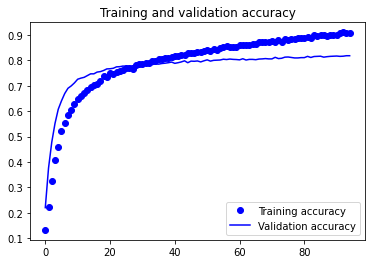

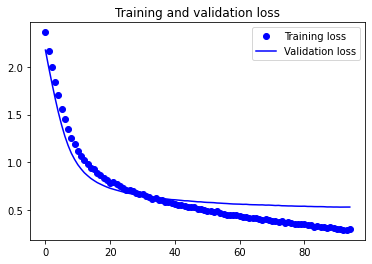

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# 🔮Hacer predicciones sobre los datos de prueba

In [ ]:
# Predecir la etiqueta de test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Mapear la etiqueta
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Mostrar el resultado
print(f'Las primeras 5 predicciones: {pred[:5]}')

The first 5 predictions: ['Moth', 'Beetles', 'Grasshopper', 'Bees', 'Cicada']


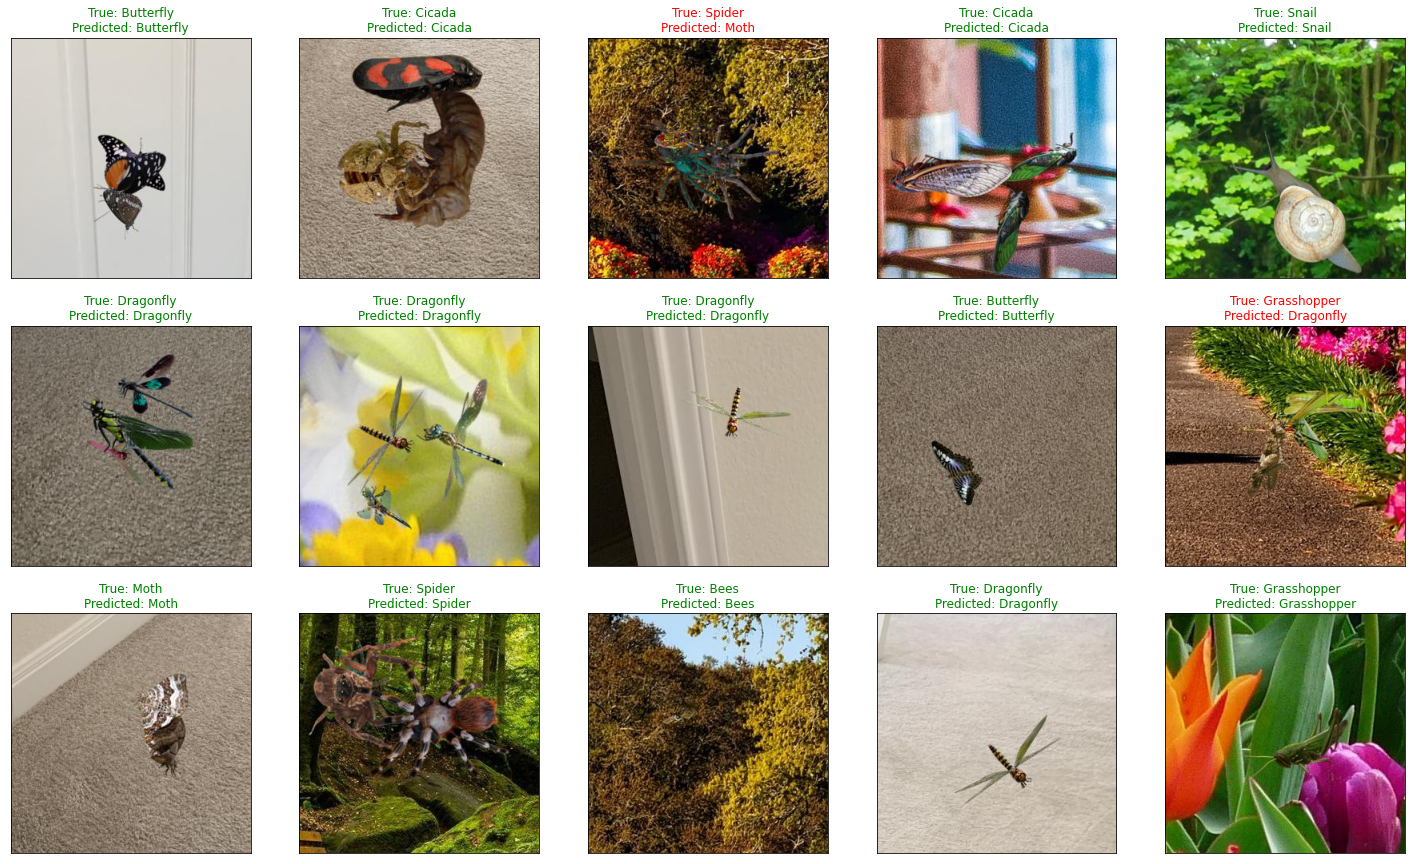

<Figure size 432x288 with 0 Axes>

In [ ]:
  # Muestre 15 imágenes aleatorias del conjunto de datos con sus etiquetas
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"Verdadero: {test_df.Label.iloc[random_index[i]]}\nPredicho: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Trazado de los informes de clasificación y matriz de confusión

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        Bees       0.71      0.83      0.77       184
     Beetles       0.83      0.75      0.79       190
   Butterfly       0.88      0.82      0.85       208
      Cicada       0.86      0.82      0.84       181
   Dragonfly       0.76      0.75      0.75       213
 Grasshopper       0.78      0.82      0.80       207
        Moth       0.77      0.81      0.79       189
    Scorpion       0.86      0.86      0.86       205
       Snail       0.99      0.98      0.98       212
      Spider       0.83      0.80      0.82       211

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.83      2000



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Bees,0.708333,0.831522,0.765000,184.0000
Beetles,0.826590,0.752632,0.787879,190.0000
Butterfly,0.880829,0.817308,0.847880,208.0000
Cicada,0.856322,0.823204,0.839437,181.0000
Dragonfly,0.757143,0.746479,0.751773,213.0000
Grasshopper,0.782407,0.816425,0.799054,207.0000
Moth,0.765000,0.809524,0.786632,189.0000
Scorpion,0.859223,0.863415,0.861314,205.0000
Snail,0.990431,0.976415,0.983373,212.0000
Spider,0.832512,0.800948,0.816425,211.0000


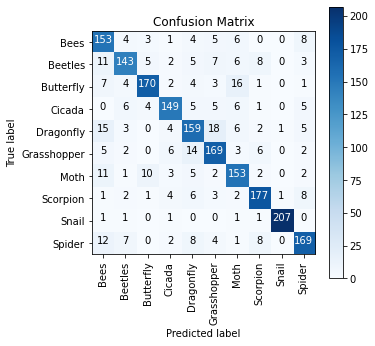

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# ☀️Visualización Grad-Cam

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # Agregamos una dimensión para transformar nuestra matriz en un "lote"
    # de tamaño "tamaño"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Primero, creamos un modelo que asigna la imagen de entrada a las activaciones
    # de la última capa de conversión, así como las predicciones de salida
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Luego, calculamos el gradiente de la clase predicha superior para nuestra imagen de entrada
    # con respecto a las activaciones de la última capa conv
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # Este es el gradiente de la neurona de salida (superior predicho o elegido)
    # con respecto al mapa de características de salida de la última capa de conversión
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Este es un vector donde cada entrada es la intensidad media del gradiente
    # sobre un canal de mapa de características específico
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicamos cada canal en la matriz del mapa de características
    # por "cuán importante es este canal" con respecto a la clase superior prevista
    # luego suma todos los canales para obtener la activación de la clase de mapa de calor  
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Para fines de visualización, también normalizaremos el mapa de calor entre 0 y 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Cargar la imagen original
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Cambiar la escala del mapa de calor a un rango de 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use el mapa de colores jet para colorear el mapa de calor
    jet = cm.get_cmap("jet")

    # Usar valores RGB del mapa de colores
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Crear una imagen con mapa de calor coloreado RGB
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superponer el mapa de calor en la imagen original
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Guardar la imagen superpuesta
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (300,300)

# Eliminar el softmax de la última capa
model.layers[-1].activation = None

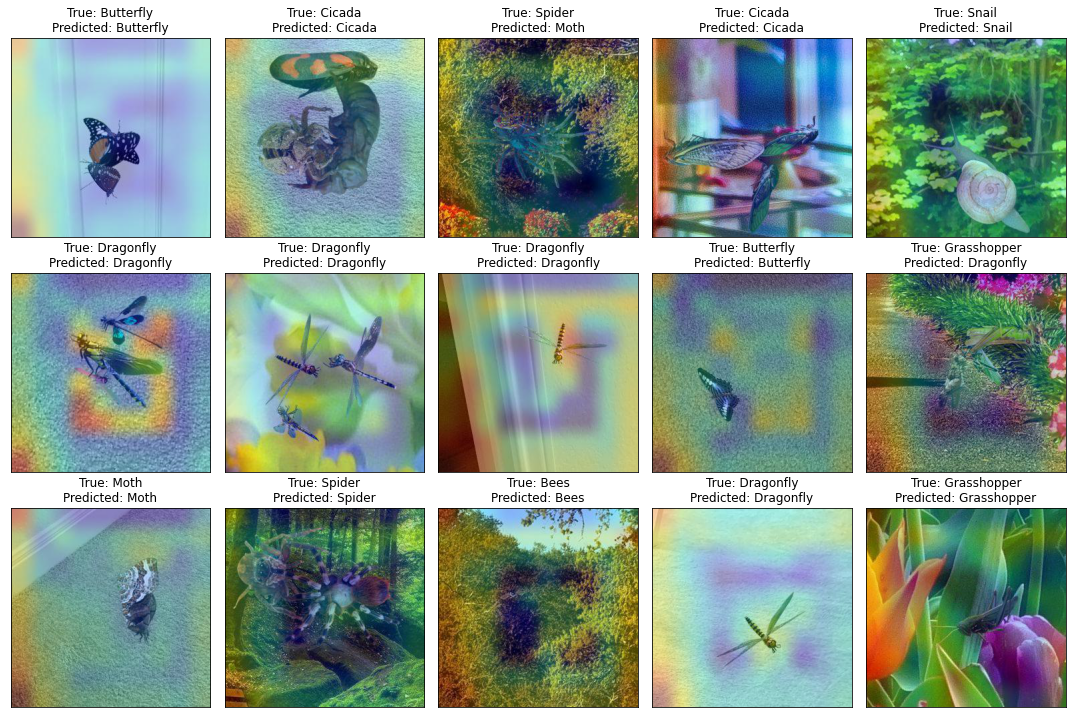

In [ ]:
# Mostrar la parte de las imágenes utilizadas por la red neuronal para clasificar las imágenes
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
#Por último, guardamos el modelo para futuras pruebas
model.save('./insectos.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
